# Cancer usecase

In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer, Embedder

from bengrn import BenGRN, get_sroy_gt
import scanpy as sc
from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils
from grnndata import read_h5ad

from scprint.tasks import Denoiser, withknn
from matplotlib import pyplot as plt
from scdataloader import utils as data_utils

import numpy as np
import lamindb as ln

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
[d3graph] INFO> Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
[d3graph] INFO> Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
[d3graph] INFO> Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
[d3graph] INFO> Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
[d3graph] INFO> Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
[d3graph] INFO> Downloading data from `https://omnipathdb.org/about?format=text`
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes

## Getting the datasets and performing embedding and annotations

1. load the datasets
   
https://cellxgene.cziscience.com/e/574e9f9e-f8b4-41ef-bf19-89a9964fd9c7.cxg/ ? prostate

https://cellxgene.cziscience.com/e/d77ec7d6-ef2e-49d6-9e79-05b7f8881484.cxg/ ? normal 

2. 

In [ ]:
anndata

In [2]:
cx_dataset = ln.Collection.using(instance="laminlabs/cellxgene").filter(name="cellxgene-census", version='2023-12-15').one()

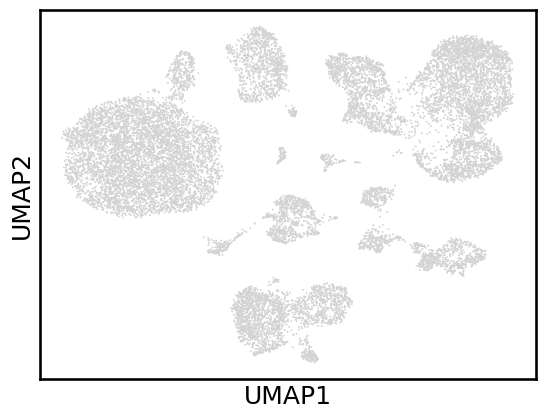

In [4]:
rostate_normal = cx_dataset.artifacts.filter(key='cell-census/2023-12-15/h5ads/d77ec7d6-ef2e-49d6-9e79-05b7f8881484.h5ad').one().load(stream=True)
sc.pl.umap(prostate_normal)

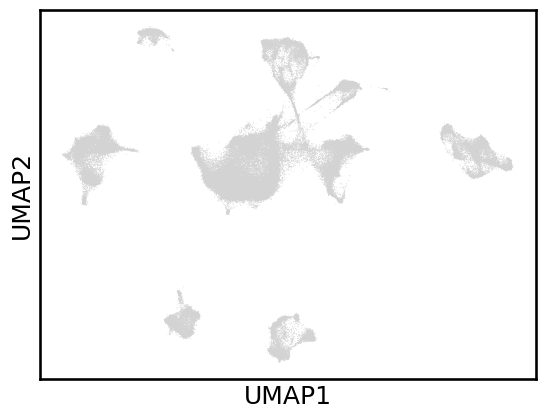

In [5]:
prostate_tumor = cx_dataset.artifacts.filter(key='cell-census/2023-12-15/h5ads/574e9f9e-f8b4-41ef-bf19-89a9964fd9c7.h5ad').one().load(stream=True)
sc.pl.umap(prostate_tumor)

In [ ]:
prostate_normal.obs.drop(columns="is_primary_data", inplace=True)
prostate_tumor.obs.drop(columns="is_primary_data", inplace=True)

In [ ]:
preprocessor = Preprocessor(subset_hvg=3000, do_postp=False)
prostate_normal = preprocessor(prostate_normal)
prostate_tumor = preprocessor (prostate_tumor)

## embed and annotate

In [ ]:
(prostate_normal.X!=0).sum(1) - mean()

In [2]:
model = scPrint.load_from_checkpoint('../data/temp/25eer0xz/epoch=20-step=105000.ckpt', precpt_gene_emb = None)

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [ ]:
embedder = Embedder(model, how="random expr", max_len=3200, add_zero_genes=0, num_workers=32, pred_embedding = ["cell_type_ontology_term_id", "disease_ontology_term_id", "sex_ontology_term_id"])

In [ ]:
prostate_combined, metrics = embedder(concat([prostate_normal, prostate_tumor], label="init_dataset"), cache=False, output_expression="none")

In [ ]:
prostate_combined.obs['cleaned_pred_cell_type_ontology_term_id'].value_counts()

## cleanup and showcase the different main annotations

<Axes: ylabel='count'>

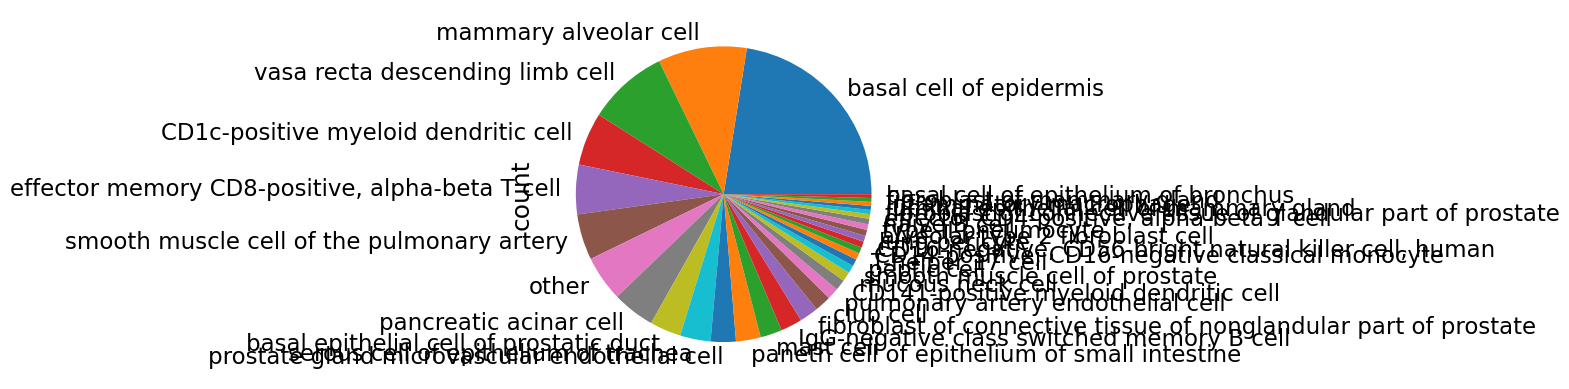

In [6]:
prostate_combined.obs['cleaned_pred_cell_type_ontology_term_id'] = prostate_combined.obs['conv_pred_cell_type_ontology_term_id'].astype(str)
prostate_combined.obs.loc[~prostate_combined.obs['conv_pred_cell_type_ontology_term_id'].isin([k for k, v in prostate_combined.obs['conv_pred_cell_type_ontology_term_id'].value_counts().items() if v > 400]), 'cleaned_pred_cell_type_ontology_term_id'] = "other"
prostate_combined.obs['cleaned_pred_cell_type_ontology_term_id'].value_counts().plot.pie()

<Axes: ylabel='count'>

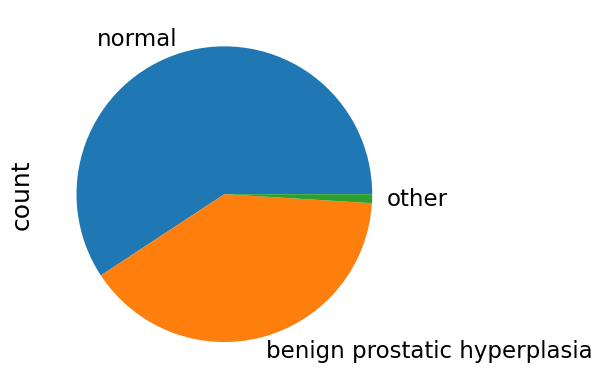

In [7]:
prostate_combined.obs['cleaned_pred_disease_ontology_term_id'] = prostate_combined.obs['conv_pred_disease_ontology_term_id'].astype(str)
prostate_combined.obs.loc[~prostate_combined.obs['conv_pred_disease_ontology_term_id'].isin([k for k, v in prostate_combined.obs['conv_pred_disease_ontology_term_id'].value_counts().items() if v > 1000]), 'cleaned_pred_disease_ontology_term_id'] = "other"
prostate_combined.obs['cleaned_pred_disease_ontology_term_id'].value_counts().plot.pie()

In [ ]:
del prostate_normal, prostate_tumor

In [ ]:
prostate_combined.write_h5ad("'../data/prostate_combined.h5ad")

In [3]:
prostate_combined = sc.read_h5ad("../data/prostate_combined.h5ad")

## Looking at one specific rare cell type and performing denoising for further analysis (here, differential expression analysis)

In [ ]:
prostate_combined.values

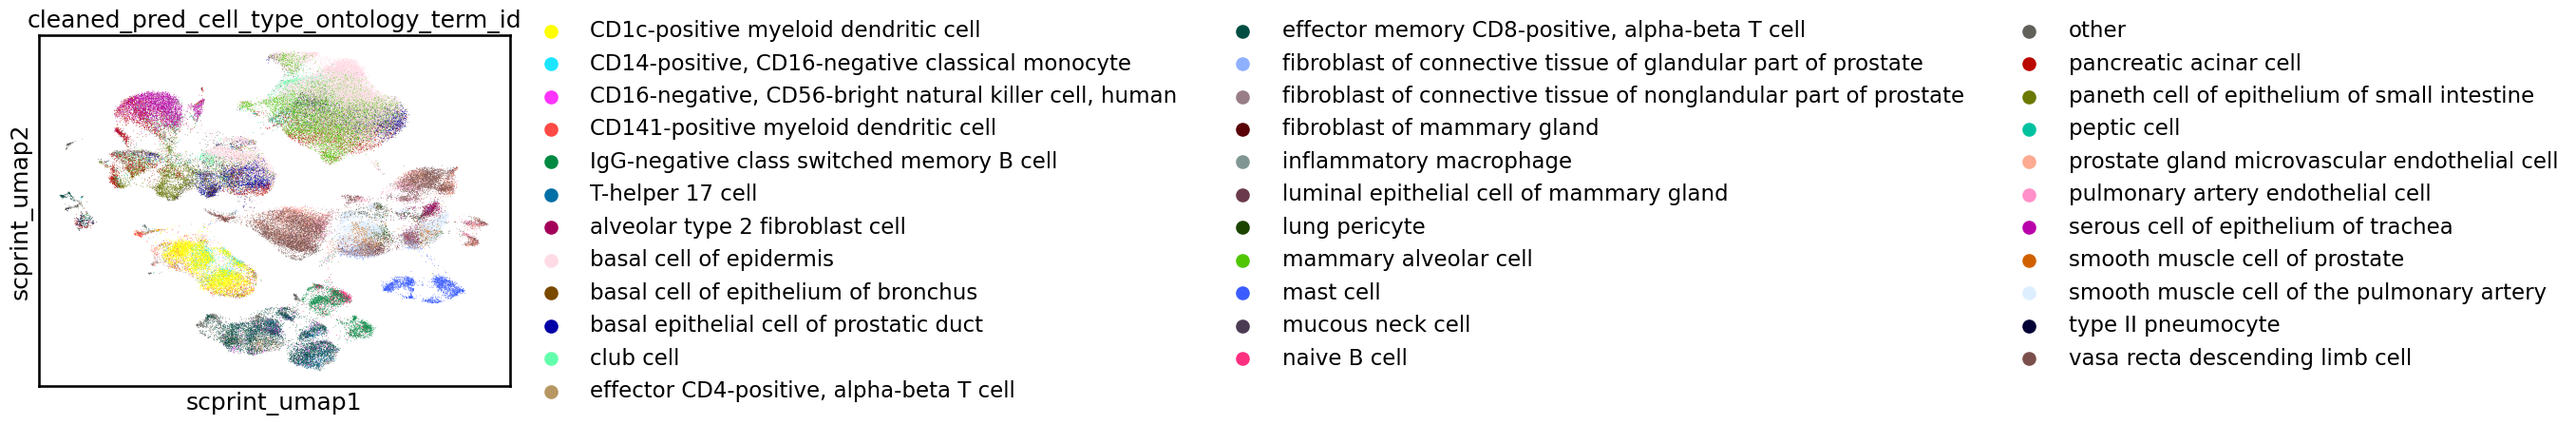

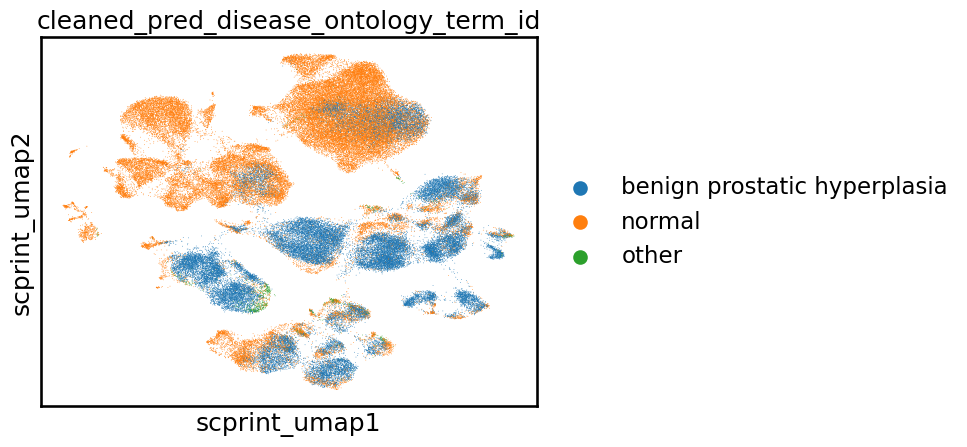

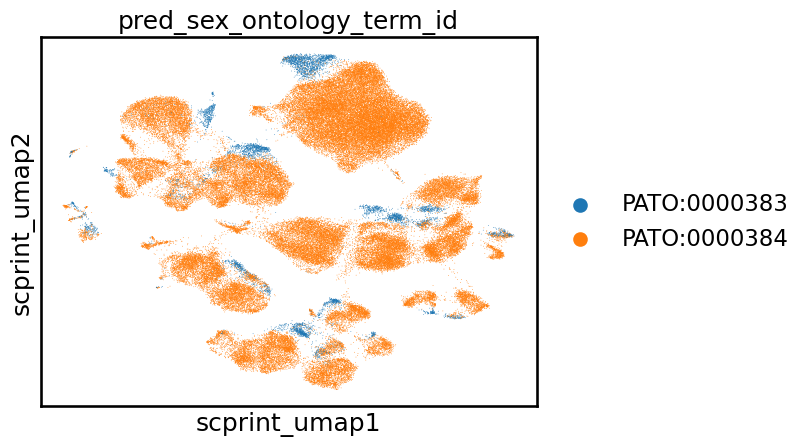

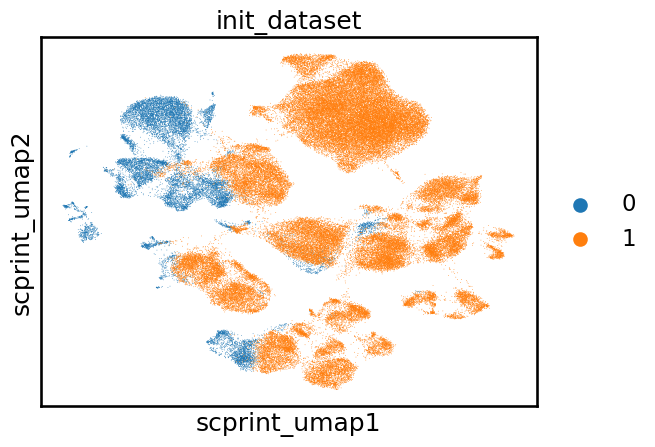

In [19]:
sc.pl.embedding(prostate_combined, basis="scprint_umap",color='cleaned_pred_cell_type_ontology_term_id', show=False)
plt. show()
sc.pl.embedding(prostate_combined, basis="scprint_umap", color='cleaned_pred_disease_ontology_term_id', show=False)
plt.show()
sc.pl.embedding(prostate_combined, basis="scprint_umap", color='pred_sex_ontology_term_id', show=False)
plt.show()
sc.pl.embedding(prostate_combined, basis="scprint_umap", color='init_dataset', show=False)
plt.show()

In [8]:
# do louvain mutliple times
sc.pp.neighbors(prostate_combined, n_neighbors=30, use_rep="scprint")
sc.tl.louvain(prostate_combined, resolution=0.5, key_added="louvain_0.5")
sc.tl.louvain(prostate_combined, resolution=1.0, key_added="louvain_1.0")

<Axes: title={'center': 'louvain_1.0'}, xlabel='scprint_umap1', ylabel='scprint_umap2'>

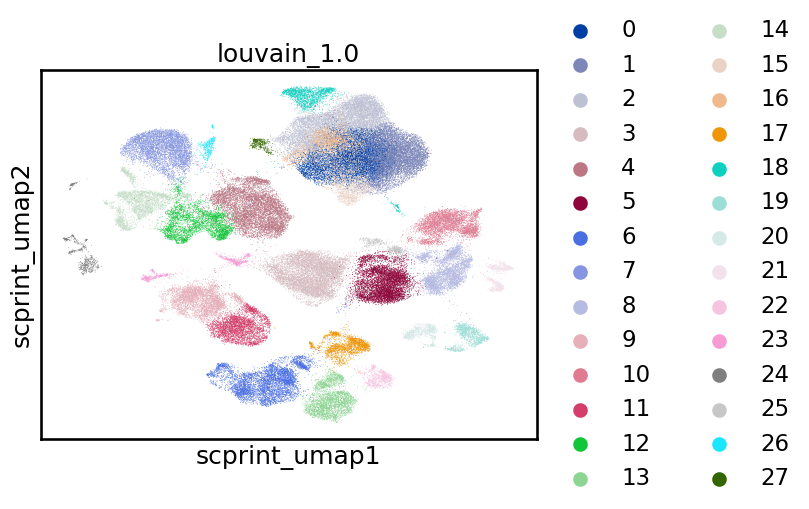

In [17]:
sc.pl.embedding(prostate_combined, basis="scprint_umap", color='louvain_1.0', show=False)

In [ ]:
prostate_combined['']

In [20]:
prostate_combined.obs['focus'] = "other"
prostate_combined.obs.loc[prostate_combined.obs['cleaned_pred_cell_type_ontology_term_id']=='naive B cell', 'focus'] = "naive B cell"
prostate_combined.obs.loc[(prostate_combined.obs['cleaned_pred_cell_type_ontology_term_id']=='naive B cell') & (prostate_combined.obs['cleaned_pred_disease_ontology_term_id']=='benign prostatic hyperplasia'), 'focus'] = "cancer associated naive B cell"

... storing 'focus' as categorical


<Axes: title={'center': 'focus'}, xlabel='scprint_umap1', ylabel='scprint_umap2'>

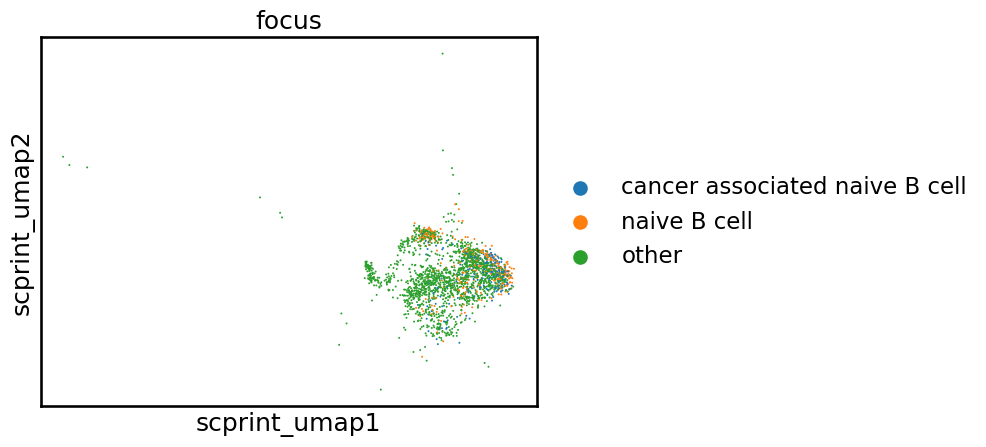

In [21]:
sc.pl.embedding(prostate_combined[prostate_combined.obs['louvain_1.0']=="17"], basis="scprint_umap",color='focus', show=False, size=8)

... storing 'focus' as categorical


<Axes: title={'center': 'focus'}, xlabel='scprint_umap1', ylabel='scprint_umap2'>

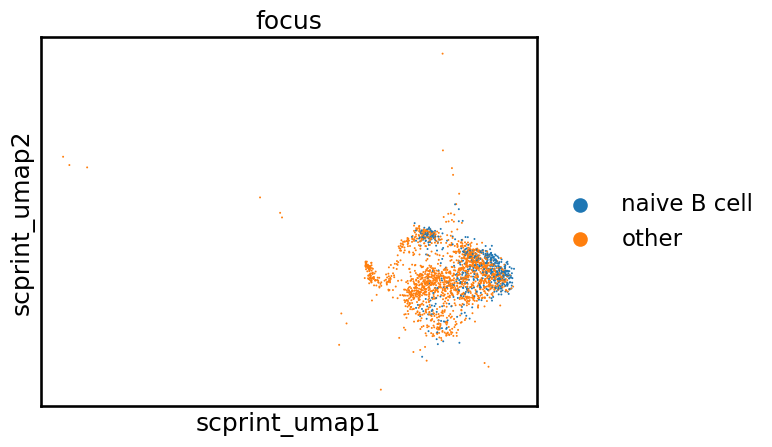

In [23]:
sc.pl.embedding(prostate_combined[prostate_combined.obs['louvain_1.0']=="17"], basis="scprint_umap",color='focus', show=False, size=8)

... storing 'focus' as categorical


<Axes: title={'center': 'cleaned_pred_cell_type_ontology_term_id'}, xlabel='scprint_umap1', ylabel='scprint_umap2'>

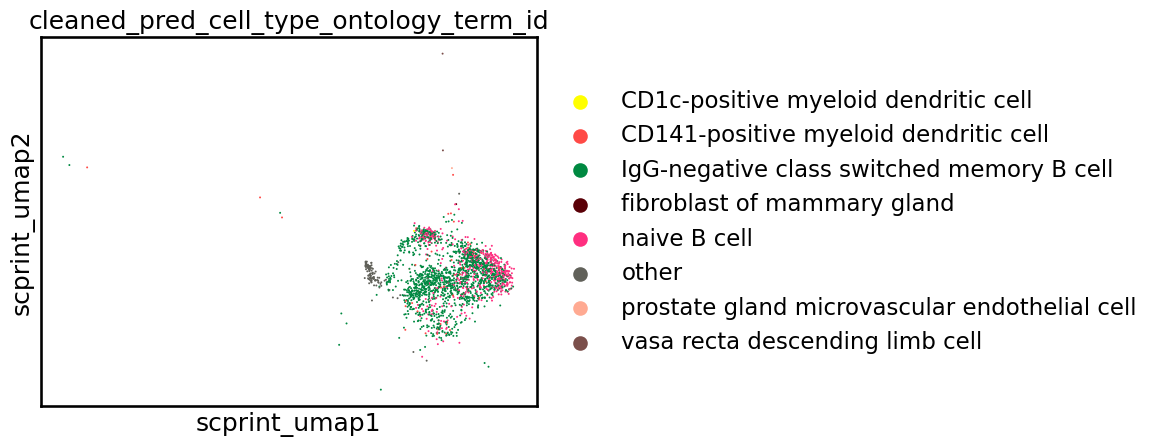

In [24]:
# plot the cell type distribution of the cells in the dataset, highlight the cells in umap
sc.pl.embedding(prostate_combined[prostate_combined.obs['louvain_1.0']=="17"], basis="scprint_umap",color='cleaned_pred_cell_type_ontology_term_id', show=False, size=8)

## perform diff expr on this small subgroup vs rest

In [10]:
genedf = data_utils.load_genes(prostate_combined.obs.organism_ontology_term_id.iloc[0])
prostate_combined.var = genedf.loc[prostate_combined.var.index].drop(columns=["stable_id", "created_at", "updated_at"])

... storing 'focus' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


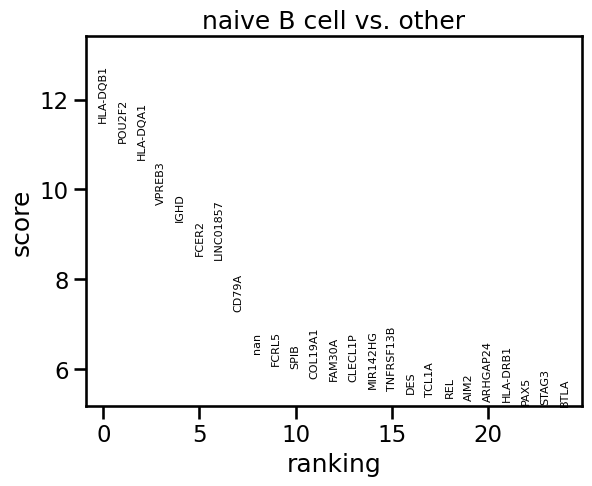

In [26]:
sc.tl.rank_genes_groups(prostate_combined, groupby='focus', groups=['naive B cell'], reference='other', method='t-test')
# Plot the most differentially expressed genes
sc.pl.rank_genes_groups(prostate_combined, n_genes=25, sharey=False, gene_symbols='symbol')
# super strong B cell markers

In [22]:
prostate_combined.write_h5ad("../data/prostate_combined.h5ad")

... storing 'focus' as categorical


## find known genes

find known genes

ALL markers 

except

HLAs nan

did not look post SPIB

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


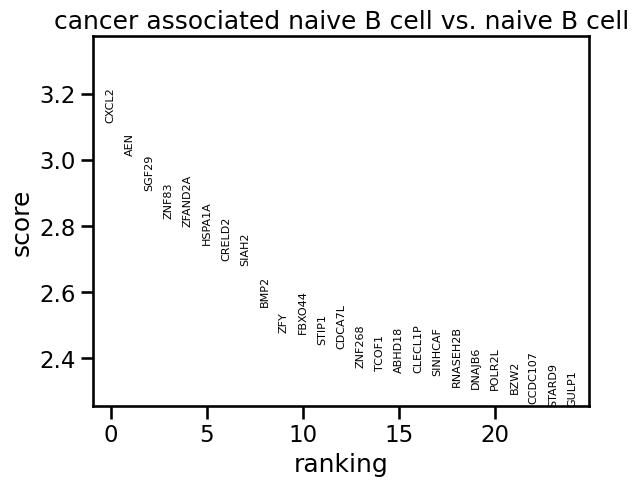

In [23]:
sc.tl.rank_genes_groups(prostate_combined, groupby='focus', groups=['cancer associated naive B cell'], reference='naive B cell', method='t-test')
# Plot the most differentially expressed genes
sc.pl.rank_genes_groups(prostate_combined, n_genes=25, sharey=False, gene_symbols='symbol')
# super strong B cell markers

In [7]:
# perform denoising
denoise = Denoiser(model, batch_size=40, max_len=5200, plot_corr_size=100_000, doplot=False, predict_depth_mult=10, how="random expr")
idx, genes, expr = denoise(prostate_combined[prostate_combined.obs['focus']!="other"])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [8]:
# recompute diff expr to rest of dataset and compare the two gene sets found
i = 0
prostate_combined.X = prostate_combined.X.tolil()
for idx, val in enumerate(prostate_combined.obs['focus']!="other"):
    if val:
        prostate_combined.X[idx, prostate_combined.var.index.get_indexer(np.array(model.genes)[genes.cpu().numpy()[i]])] = expr[i].cpu().numpy()
        i += 1
prostate_combined.X = prostate_combined.X.tocsr()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


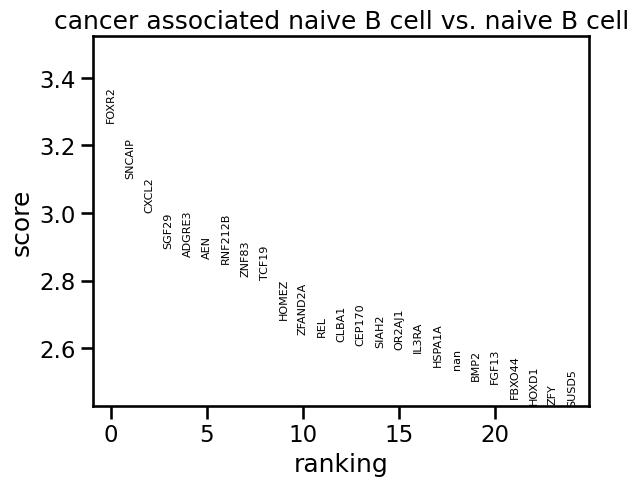

In [29]:
# highlight diff expr genes in fibroblasts and CAFs
sc.tl.rank_genes_groups(prostate_combined, groupby='focus', groups=['cancer associated naive B cell'], reference='naive B cell', method='t-test')
# Plot the most differentially expressed genes
sc.pl.rank_genes_groups(prostate_combined, n_genes=25, sharey=False, gene_symbols='symbol')
# super strong B cell markers

In [9]:
prostate_combined.write_h5ad("../data/prostate_combined_denoised.h5ad")

# find new genes
LRRC56:
- highest expression in prostate cancer according to TCGA
- more in prostate cancer than in normal prostate
- involved in cell movement (B cell for example) (involved in Dynein Axonemal Assembly Factor 12)
SPANA - much. higher

IFNA17:
interferon associated with B cell activation

## extracting Gene Regulatory networks and comparing two networks

In [21]:
grn_inferer = GRNfer(model, prostate_combined,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=prostate_combined.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=4000,
                     max_cells=300,
                     doplot=False,
                     batch_size=16,
                     cell_type_col='focus',
                     )

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
# compute GRNs on fibroblasts and CAFs
grn = grn_inferer(layer=list(range(model.nlayers))[:], cell_type="cancer associated naive B cell")
grn, m, omni_cls = train_classifier(grn, C=0.5, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


ValueError: b'There are other near singularities as well. 0.090619'

In [34]:
# highlight differential links on genes that are expressed in both 
grn.varp['all'] = grn.varp['GRN'].copy()
grn.varp['GRN'] = grn.varp['classified']

In [45]:
grn.plot_subgraph("AEN")


['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e'] Index(['BTG1', 'H3-3A', 'CD74', 'HSPD1', 'HLA-A', 'STK10', 'GARIN2',
       'HSP90AA1', 'CXCR4', 'UBC', 'AEN'],
      dtype='object')


[d3graph] INFO> Set directed=True to see the markers!
[d3graph] INFO> Keep only edges with weight>0
[d3graph] INFO> Converting source-target into adjacency matrix..
[d3graph] INFO> Making the matrix symmetric..
[d3graph] INFO> Number of unique nodes: 11
[d3graph] INFO> Number of unique nodes: 11
[d3graph] INFO> Keep only edges with weight>0
[d3graph] INFO> Converting source-target into adjacency matrix..
[d3graph] INFO> Making the matrix symmetric..
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/tmpus1_fk8x'>
  _warnings.warn(warn_message, ResourceWarning)
[d3graph] INFO> Slider range is set to [29, 100]
[d3graph] INFO> Write to path: [/tmp/tmpus1_fk8x/d3graph.html]
[d3graph] INFO> File already exists and will be overwritten: [/tmp/tmpus1_fk8x/d3graph.html]


In [88]:
grn.write_h5ad("../data/prostate_cancerBcell_grn.h5ad")

In [44]:
grn = read_h5ad("../data/prostate_cancerBcell_grn.h5ad")

In [17]:
grn_normal

GRnnData object with n_obs × n_vars = 300 × 2059
    obs: 'assay_ontology_term_id', 'donor_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'init_dataset', 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_t

number of expressed genes in this cell type: 16801


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

true elem 2115 ...
doing regression....
metrics {'used_heads': 25, 'precision': 0.0, 'random_precision': 0.0006433550820644942, 'recall': 0.0, 'predicted_true': 177.0, 'number_of_true': 219.0, 'epr': 0.0}


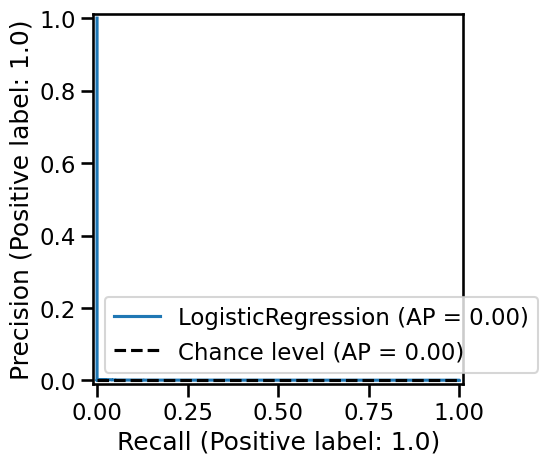

In [22]:
grn_normal = grn_inferer(layer=list(range(model.nlayers))[:], cell_type="naive B cell")
grn_normal, m, omni_cls = train_classifier(grn_normal, C=0.5, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True)

In [23]:
# highlight differential links on genes that are expressed in both 
grn_normal.varp['all'] = grn_normal.varp['GRN'].copy()
grn_normal.varp['GRN'] = grn_normal.varp['classified']

In [46]:
# find known genes and connections
grn_normal.plot_subgraph("AEN")

['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e'] Index(['C11orf52', 'HSP90AA1', 'ADGRL3', 'CXCR4', 'MT-ND4', 'MT-CYB', 'MT-CO1',
       'DIXDC1', 'COL4A1', 'DDI1', 'AEN'],
      dtype='object')


[d3graph] INFO> Set directed=True to see the markers!
[d3graph] INFO> Keep only edges with weight>0
[d3graph] INFO> Converting source-target into adjacency matrix..
[d3graph] INFO> Making the matrix symmetric..
[d3graph] INFO> Number of unique nodes: 11
[d3graph] INFO> Number of unique nodes: 11
[d3graph] INFO> Keep only edges with weight>0
[d3graph] INFO> Converting source-target into adjacency matrix..
[d3graph] INFO> Making the matrix symmetric..
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/tempfile.py:833: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/tmpug7ckdku'>
  _warnings.warn(warn_message, ResourceWarning)
[d3graph] INFO> Slider range is set to [30, 100]
[d3graph] INFO> Write to path: [/tmp/tmpug7ckdku/d3graph.html]
[d3graph] INFO> File already exists and will be overwritten: [/tmp/tmpug7ckdku/d3graph.html]


In [ ]:
# find new connections